In [1]:
import ira
%alphalab dark

%run initlibs.py Lustre dark
from tools.loaders.data_loaders import load_data, load_instrument_data
from tools.charting.signals_charts import plot_entries

import qlearn as q
from sklearn.base import BaseEstimator
import seaborn as sns

%run trackers.py
%run generators.py
%run indicators.py

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


<hr/>
Simple breakout system based on weekly timeframe but would like to see if it can work on daily as well

For entering long trades we use

   <font color='orange'>C > (Ref(C,-1) + .75*ATR(15) and C > Mov(C,150,E) and V >= Mov(V,10,W))</font>

For short we use

   <font color='orange'>C < (Ref(C,-1) - .75*ATR(15) and C < Mov(C,150,E) and V >= Mov(V,10,W))</font>

(Note above is only for initial entry , not the pyramid entries). If were in long trades we don't open a short and vica versa.

Initial stop would be rad chandlier 3atr stop. If we are going long once it goes up by 3atr we move the stop to break even. We then apply a 5 atr trailing stop once its goes up enough to do so.
<hr/>

In [2]:
md = load_data('amp:AUS200', 'amp:SPXM', 'amp:XTIUSD')

First we find out average bid/ask spreads (as because we do not have tick data but we want to take in account slippages). Probably it will not play significant role on daily entries but it always worth to be taken in account.

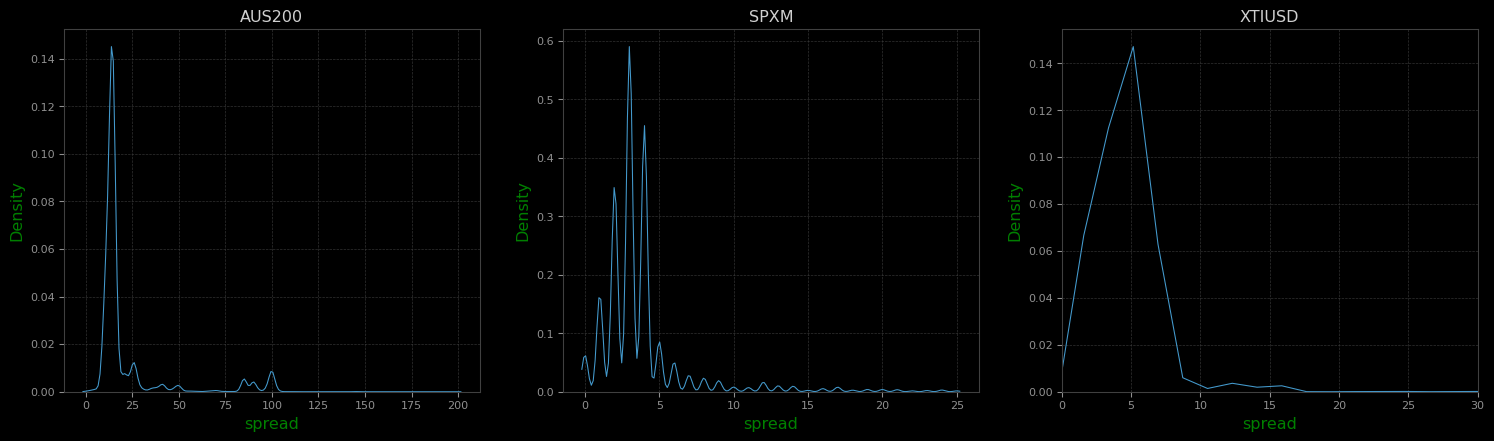

In [114]:
fig(19, 5)
sbp(13,1); sns.kdeplot(md.ticks()['AUS200'].spread, cut=1); plt.title('AUS200')
sbp(13,2); sns.kdeplot(md.ticks()['SPXM'].spread, cut=1); plt.title('SPXM')
sbp(13,3); sns.kdeplot(md.ticks()['XTIUSD'].spread, cut=1); plt.title('XTIUSD'); plt.xlim(0,30);

So we can use 15 ticks for AUS, 5 for SPXM and 5 for XTI

In [3]:
spreads = {
   'AUS200': 15*0.1,
   'SPXM': 5*0.1,
   'XTIUSD': 5*0.01,
}

# Basic model (no pyramid entries) tests

In [4]:
lbr = q.SingleInstrumentComposer(Lustre('1d', 14, 0.75, 150, 10)).fit(md.ticks())

In [ ]:
epf = lbr.estimated_portfolio(md.ticks(), q.ReverseSignalsSharpeScoring(commissions=100*0.25))
plt.plot(epf.fillna(0).cumsum())

Now we will run this model fro AUS200 index using different setups for RAD stops: 
   - here we could variate days in ATR period (let's say 12, 22)
   - and ATR stop multiplier (3,4,5)

Now we will run this model for AUS200, SPXM and XTIUSD CFD's on existing data (daily timeframe). 
Here for comparison we also run signals with no any tracking logic (<font color='red'>FixedTracker</font>) that wouldn't do any risk manegement job but only opens position and waits for opposite signal (reversive trading)

Here we use following info from AMP futures:
   - AUS200: tick size = 0.1, contract size = 1, tick_price = \\$0.1
   - SPXm: tick size = 0.1, contract size = 10, tick_price = \\$1
   - XTIUSD: tick size = 0.01, contract size = 100, tick_price = \\$1

In [ ]:
r_aus = q.simulation({
    'Basic / no RM (aus200)': [lbr, q.FixedTrader(1, 0, 0)], 
    'Basic / RAD(daily, 12 x 3)': [lbr, RADChandelier(1, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3)': [lbr, RADChandelier(1, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4)': [lbr, RADChandelier(1, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4)': [lbr, RADChandelier(1, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5)': [lbr, RADChandelier(1, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5)': [lbr, RADChandelier(1, '1d', 22, 5)], 
}, md['AUS200'].ohlcs('5Min'), 'stock', 'Lustre AUS200 1D', spreads=spreads)

In [ ]:
r_spx = q.simulation({
    'Basic / no RM (spx)': [lbr, q.FixedTrader(10, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (spx)': [lbr, RADChandelier(10, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (spx)': [lbr, RADChandelier(10, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (spx)': [lbr, RADChandelier(10, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (spx)': [lbr, RADChandelier(10, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (spx)': [lbr, RADChandelier(10, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (spx)': [lbr, RADChandelier(10, '1d', 22, 5)], 
}, md['SPXM'].ohlcs('5Min'), 'stock', 'Lustre SPXM 1D', spreads=spreads)

In [ ]:
r_xti = q.simulation({
    'Basic / no RM (xti)': [lbr, q.FixedTrader(100, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (xti)': [lbr, RADChandelier(100, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (xti)': [lbr, RADChandelier(100, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (xti)': [lbr, RADChandelier(100, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (xti)': [lbr, RADChandelier(100, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (xti)': [lbr, RADChandelier(100, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (xti)': [lbr, RADChandelier(100, '1d', 22, 5)], 
}, md['XTIUSD'].ohlcs('5Min'), 'stock', 'Lustre XTI 1D', spreads=spreads)

Following is simulation results for every symbol
<hr/>

 0: Lustre AUS200 1D/Basic / no RM (aus200)      : Sharpe: -inf | Sortino: -0.23 | CAGR: -52.61 | DD: $2729.50 (89.30%) | Gain: $295.80 | Execs: 15[OK]
 1: Lustre AUS200 1D/Basic / RAD(daily, 12 x 3)  : Sharpe: 0.24 | Sortino: 0.37 | CAGR: -1.22 | DD: $2364.20 (70.98%) | Gain: $-26.40 | Execs: 27[OK]
 2: Lustre AUS200 1D/Basic / RAD(daily, 22 x 3)  : Sharpe: 0.40 | Sortino: 0.65 | CAGR: 8.57 | DD: $1488.00 (56.94%) | Gain: $195.90 | Execs: 19[OK]
 3: Lustre AUS200 1D/Basic / RAD(daily, 12 x 4)  : Sharpe: 0.61 | Sortino: 0.98 | CAGR: 20.80 | DD: $1900.60 (58.59%) | Gain: $508.30 | Execs: 25[OK]
 4: Lustre AUS200 1D/Basic / RAD(daily, 22 x 4)  : Sharpe: 0.64 | Sortino: 0.99 | CAGR: 23.06 | DD: $2140.30 (66.72%) | Gain: $570.30 | Execs: 17[OK]
 5: Lustre AUS200 1D/Basic / RAD(daily, 12 x 5)  : Sharpe: 0.82 | Sortino: 1.35 | CAGR: 37.56 | DD: $1312.80 (45.22%) | Gain: $1000.70 | Execs: 9[OK]
 6: Lustre AUS200 1D/Basic / RAD(daily, 22 x 5)  : Sharpe: 0.83 | Sortino: 1.32 | CAGR: 41.01 | DD:

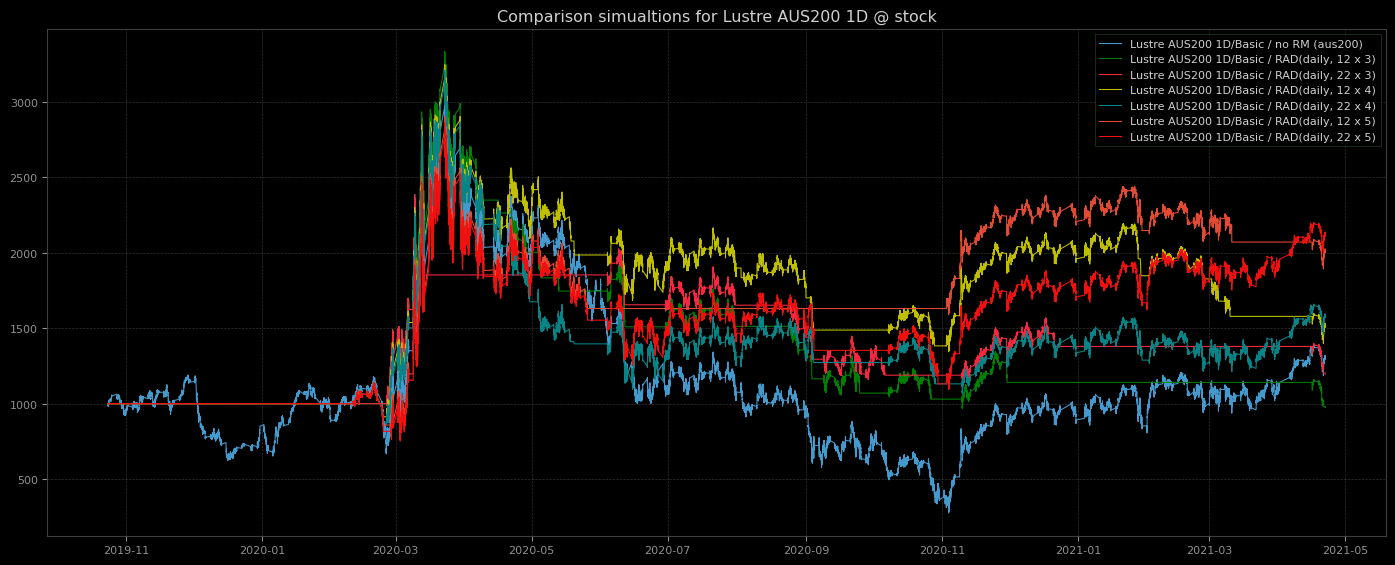

In [15]:
fig(18, 7)
res_aux = r_aus.report(1000, commissions=100*2.5)

 0: Lustre SPXM 1D/Basic / no RM (spx)               : Sharpe: 1.61 | Sortino: 2.88 | CAGR: 269.93 | DD: $9606.00 (92.61%) | Gain: $12265.00 | Execs: 5[OK]
 1: Lustre SPXM 1D/Basic / RAD(daily, 12 x 3) (spx)  : Sharpe: -inf | Sortino: -0.07 | CAGR: -96.34 | DD: $3673.00 (92.57%) | Gain: $143.00 | Execs: 21[OK]
 2: Lustre SPXM 1D/Basic / RAD(daily, 22 x 3) (spx)  : Sharpe: -inf | Sortino: 0.61 | CAGR: -82.89 | DD: $3642.00 (91.78%) | Gain: $3954.00 | Execs: 17[OK]
 3: Lustre SPXM 1D/Basic / RAD(daily, 12 x 4) (spx)  : Sharpe: -inf | Sortino: -1.70 | CAGR: -99.35 | DD: $994.00 (75.25%) | Gain: $6010.00 | Execs: 29[OK]
 4: Lustre SPXM 1D/Basic / RAD(daily, 22 x 4) (spx)  : Sharpe: -inf | Sortino: -0.46 | CAGR: -97.89 | DD: $1201.00 (79.12%) | Gain: $314.00 | Execs: 21[OK]
 5: Lustre SPXM 1D/Basic / RAD(daily, 12 x 5) (spx)  : Sharpe: -inf | Sortino: -0.97 | CAGR: -97.61 | DD: $1301.00 (79.82%) | Gain: $4796.00 | Execs: 25[OK]
 6: Lustre SPXM 1D/Basic / RAD(daily, 22 x 5) (spx)  : Sharpe: 

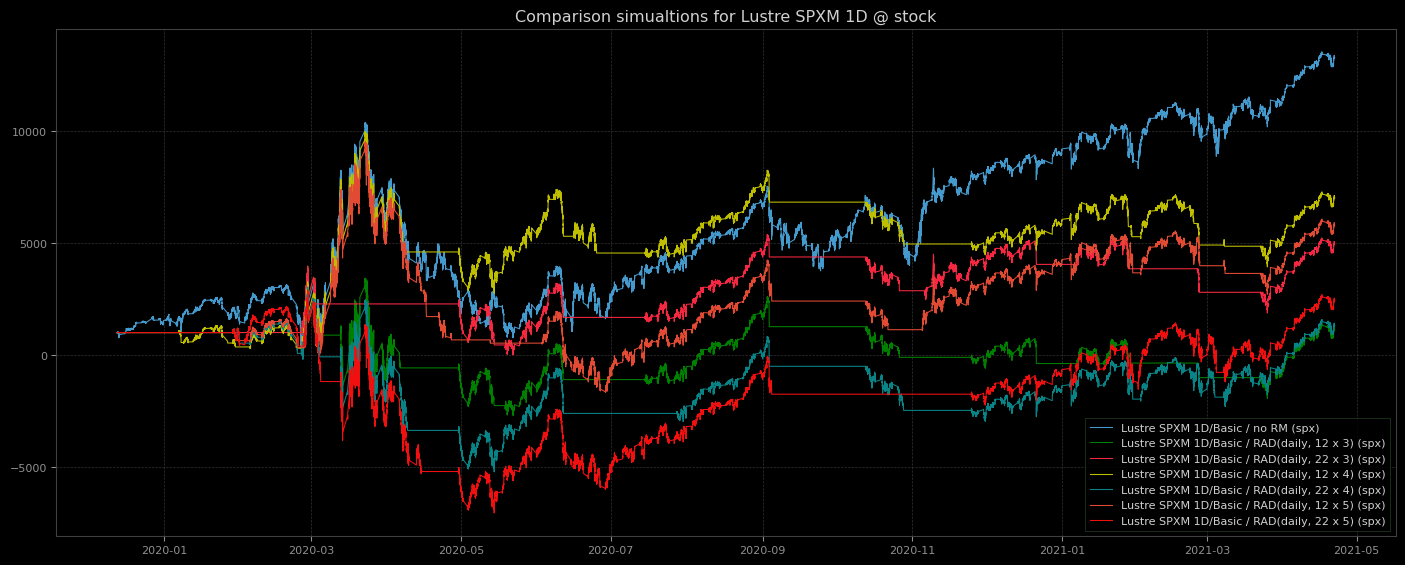

In [16]:
fig(18, 7)
res_spx = r_spx.report(1000, commissions=100*2.5)

 0: Lustre XTI 1D/Basic / no RM (xti)               : Sharpe: -inf | Sortino: -3.01 | CAGR: -99.57 | DD: $777.00 (70.51%) | Gain: $2930.00 | Execs: 10[OK]
 1: Lustre XTI 1D/Basic / RAD(daily, 12 x 3) (xti)  : Sharpe: 1.06 | Sortino: 1.82 | CAGR: 65.09 | DD: $2020.00 (51.78%) | Gain: $2108.00 | Execs: 23[OK]
 2: Lustre XTI 1D/Basic / RAD(daily, 22 x 3) (xti)  : Sharpe: 1.06 | Sortino: 2.07 | CAGR: 69.66 | DD: $1551.00 (41.68%) | Gain: $2306.00 | Execs: 25[OK]
 3: Lustre XTI 1D/Basic / RAD(daily, 12 x 4) (xti)  : Sharpe: 1.09 | Sortino: 1.85 | CAGR: 72.05 | DD: $2455.00 (54.47%) | Gain: $2412.00 | Execs: 19[OK]
 4: Lustre XTI 1D/Basic / RAD(daily, 22 x 4) (xti)  : Sharpe: 1.51 | Sortino: 2.66 | CAGR: 107.35 | DD: $1812.00 (33.39%) | Gain: $4204.00 | Execs: 15[OK]
 5: Lustre XTI 1D/Basic / RAD(daily, 12 x 5) (xti)  : Sharpe: 0.99 | Sortino: 1.73 | CAGR: 55.19 | DD: $3012.00 (58.39%) | Gain: $1702.00 | Execs: 11[OK]
 6: Lustre XTI 1D/Basic / RAD(daily, 22 x 5) (xti)  : Sharpe: 1.30 | Sorti

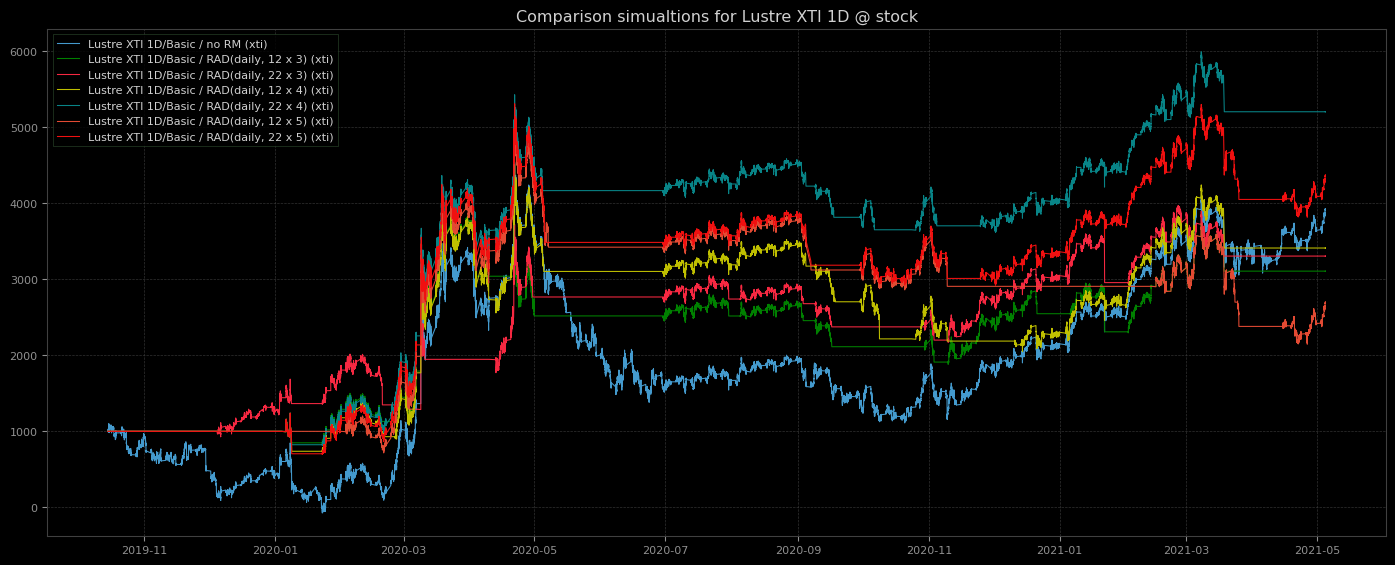

In [17]:
fig(18, 7)
res_xti = r_xti.report(1000, commissions=100*2.5)

<font size=3>Results </font>
<hr/>

In [18]:
res_aux.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
6,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 5)",0.833251,1.319777,41.014741,1769.9,61.854337,1111.5,9
5,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 5)",0.822081,1.353324,37.562398,1312.8,45.215954,1000.7,9
4,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 4)",0.640298,0.990685,23.061839,2140.3,66.719661,570.3,17
3,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 4)",0.610749,0.977181,20.803161,1900.6,58.589969,508.3,25
2,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 3)",0.403004,0.653080,8.574614,1488.0,56.943860,195.9,19
1,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 3)",0.237227,0.365077,-1.222790,2364.2,70.982076,-26.4,27
0,Lustre AUS200 1D/Basic / no RM (aus200),-inf,-0.234143,-52.610272,2729.5,89.295646,295.8,15


In [19]:
res_spx.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre SPXM 1D/Basic / no RM (spx),1.614972,2.878434,269.927761,9606.0,92.605804,12265.0,5
1,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 3) (spx)",-inf,-0.074398,-96.340779,3673.0,92.565524,143.0,21
2,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 3) (spx)",-inf,0.610509,-82.887332,3642.0,91.784274,3954.0,17
3,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 4) (spx)",-inf,-1.702024,-99.346170,994.0,75.246026,6010.0,29
4,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 4) (spx)",-inf,-0.457220,-97.893511,1201.0,79.117260,314.0,21
5,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 5) (spx)",-inf,-0.969257,-97.613408,1301.0,79.815951,4796.0,25
6,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 5) (spx)",-inf,3.084295,-99.586808,2716.0,94.305556,1421.0,15


In [20]:
res_xti.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
4,"Lustre XTI 1D/Basic / RAD(daily, 22 x 4) (xti)",1.513377,2.657349,107.346393,1812.0,33.388612,4204.0,15
6,"Lustre XTI 1D/Basic / RAD(daily, 22 x 5) (xti)",1.301044,2.090562,91.976499,2385.0,44.932178,3372.0,13
3,"Lustre XTI 1D/Basic / RAD(daily, 12 x 4) (xti)",1.087827,1.847210,72.046600,2455.0,54.470823,2412.0,19
2,"Lustre XTI 1D/Basic / RAD(daily, 22 x 3) (xti)",1.064964,2.070989,69.662758,1551.0,41.682343,2306.0,25
1,"Lustre XTI 1D/Basic / RAD(daily, 12 x 3) (xti)",1.055215,1.824275,65.092919,2020.0,51.781594,2108.0,23
5,"Lustre XTI 1D/Basic / RAD(daily, 12 x 5) (xti)",0.994265,1.731186,55.185222,3012.0,58.394727,1702.0,11
0,Lustre XTI 1D/Basic / no RM (xti),-inf,-3.010559,-99.568966,777.0,70.508167,2930.0,10


We can see that only applying RAD exits (no pyramiding) led to improvements (exepting SPXM - here simple reversive model gave most profitable results).

Also main concern here is small number of signals

In [23]:
r_aus.results[4].executions

,instrument,quantity,exec_price,comment
2020-02-10 23:59:59,AUS200,1,7056.25,
2020-02-24 08:14:00,AUS200,-1,6933.45,stop long at 6934.95
2020-02-25 23:59:59,AUS200,-1,6744.75,
2020-04-17 02:34:00,AUS200,1,5579.45,stop short at 5577.95
2020-04-21 23:59:59,AUS200,-1,5137.55,
2020-04-30 03:24:00,AUS200,1,5505.05,stop short at 5503.55
2020-05-01 23:59:59,AUS200,-1,5238.25,
2020-05-18 08:34:00,AUS200,1,5502.75,stop short at 5501.25
2020-05-19 23:59:59,AUS200,-1,5491.35,
2020-05-20 00:04:00,AUS200,1,5505.85,stop short at 5504.35


Let's see how these signals were performed on charts

Best model for AUS200
<hr/>

In [25]:
lbr.predict(md['AUS200'].ohlcs('1h'))

,AUS200
time,
2019-10-23 23:59:59,1
2019-11-07 23:59:59,1
2019-11-14 23:59:59,1
2019-12-03 23:59:59,-1
2020-01-02 23:59:59,1
2020-01-06 23:59:59,1
2020-01-08 23:59:59,1
2020-02-10 23:59:59,1
2020-02-25 23:59:59,-1


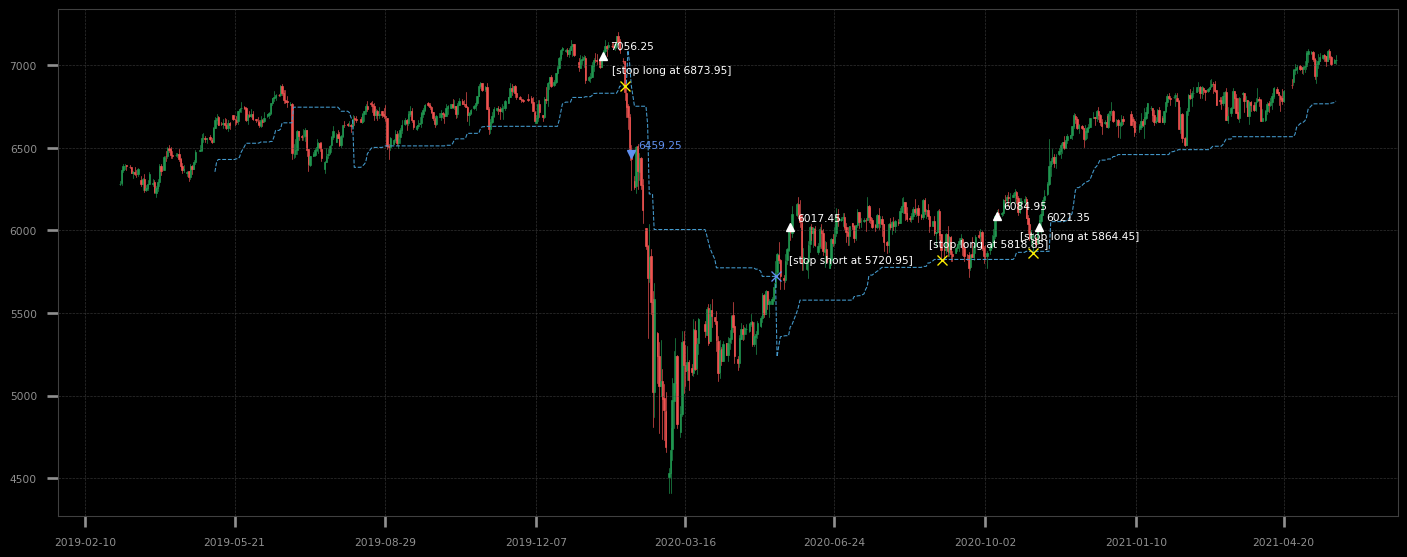

In [22]:
fig(18, 7)
rd = rad_indicator(md['AUS200'].ohlc('1d'), 22, 5, 'sma')
ohlc_plot(md['AUS200'].ohlc('1d'))
plt.plot(rd.rad.shift(1), '--')
plot_entries(r_aus.results[6].executions, font_size=8, ms=7)

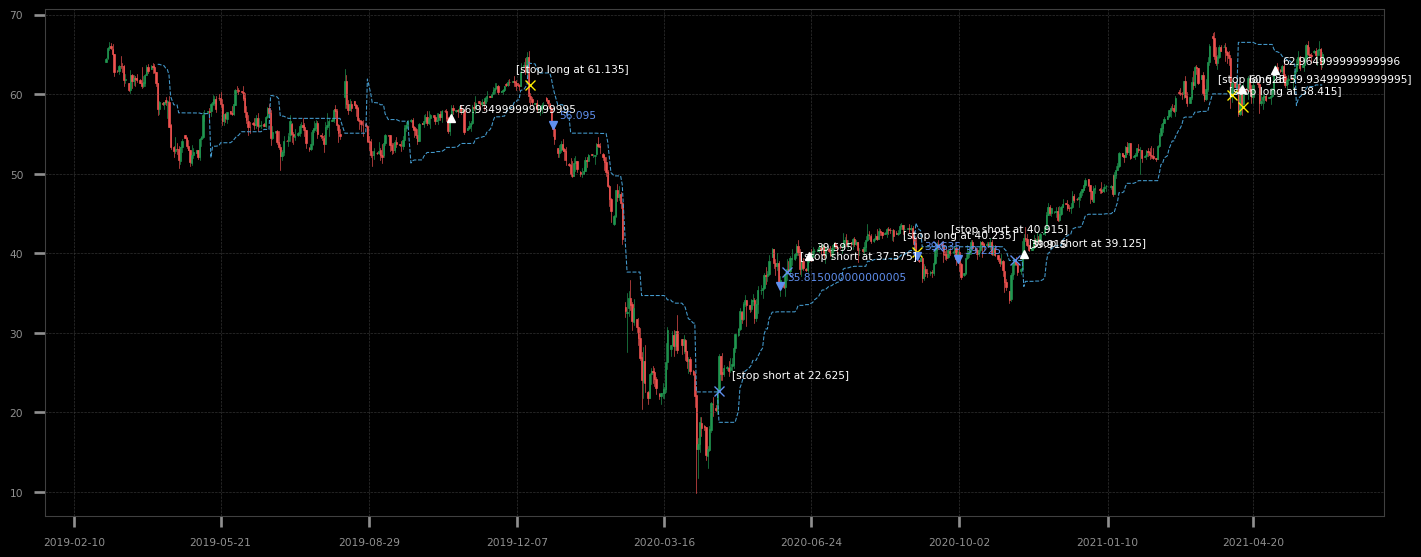

In [105]:
fig(18, 7)
rd = rad_indicator(md['XTIUSD'].ohlc('1d'), 22, 4, 'sma')

ohlc_plot(md['XTIUSD'].ohlc('1d'))
plt.plot(rd.rad, '--')
plot_entries(r_xti.results[4].executions, font_size=8, ms=7)

In [ ]:
r_xti.results[5].executions